# 1. Import Necessary Libraries

In [33]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import Holt 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as smf


import warnings
warnings.filterwarnings('ignore')

# 2.Import Data

In [34]:
Airlines_Data=pd.read_excel('Airlines+Data.xlsx')
Airlines_Data.head(10).T

,0,1,2,3,4,5,6,7,8,9
Month,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,1995-10-01 00:00:00
Passengers,112,118,132,129,121,135,148,148,136,119


# 3.Data Understanding 

In [35]:
Airlines_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [36]:
Airlines_Data.shape

(96, 2)

In [37]:
Airlines_Data.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [38]:
Airlines_Data.isnull().sum()

Month         0
Passengers    0
dtype: int64

<AxesSubplot:xlabel='Month', ylabel='Passengers'>

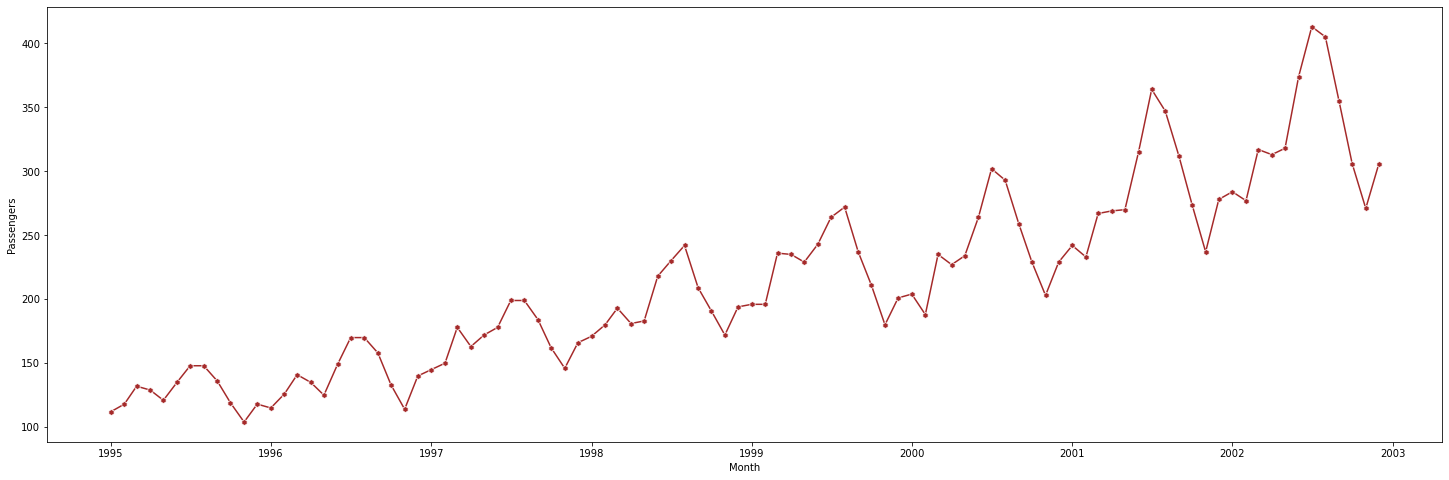

In [39]:
fig, ax = plt.subplots(figsize=(25, 8))
sns.lineplot(x = "Month",y = "Passengers", data = Airlines_Data, color = "brown", marker = "h")


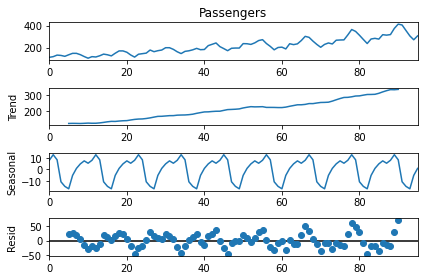

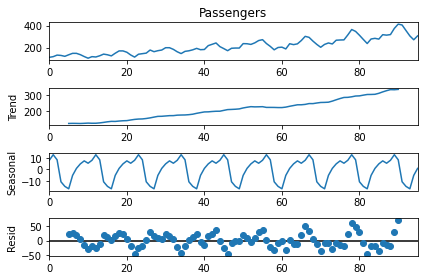

In [40]:
seasonal_ts_add=smf.tsa.seasonal_decompose(Airlines_Data["Passengers"],period=11)
seasonal_ts_add.plot()


In [41]:
Airlines_Data['Month'] = pd.to_datetime(Airlines_Data['Month'])
Airlines_Data['Months'] = Airlines_Data['Month'].dt.strftime('%b')
Airlines_Data.head()
# Let's Make a Months Column

,Month,Passengers,Months
0,1995-01-01,112,Jan
1,1995-02-01,118,Feb
2,1995-03-01,132,Mar
3,1995-04-01,129,Apr
4,1995-05-01,121,May


<AxesSubplot:>

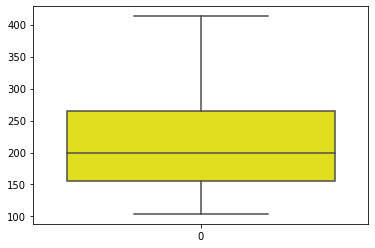

In [42]:
sns.boxplot(data=Airlines_Data['Passengers'],color='yellow')


In [43]:
month_dummies = pd.DataFrame(pd.get_dummies(Airlines_Data['Months']))
airline1 = pd.concat([Airlines_Data,month_dummies],axis = 1)
airline1.head()
#Let's Create Dummies of Month So,we'll get Pattern

,Month,Passengers,Months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0


In [44]:
airline1["t"] = np.arange(1,97)
airline1["t_squared"] = airline1["t"]*airline1["t"]
airline1["log_Passengers"] = np.log(airline1["Passengers"])
airline1.columns
airline1.head()
# Let's Make a t,t-squared & log_Passengers features

,Month,Passengers,Months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_squared,log_Passengers
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0,1,1,4.718499
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0,2,4,4.770685
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0,3,9,4.882802
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0,4,16,4.859812
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0,5,25,4.795791


# Visualization

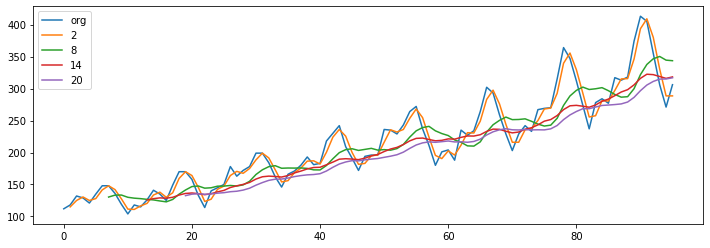

In [45]:
plt.figure(figsize=(12,4))
airline1.Passengers.plot(label="org")
for i in range(2,24,6):
    airline1["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')


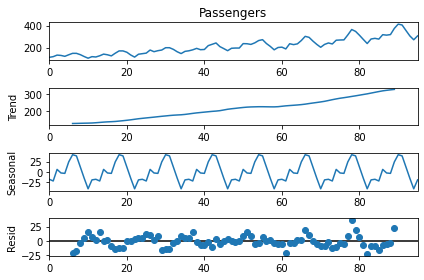

In [18]:
decompose_ts_add = seasonal_decompose(airline1.Passengers,period=12)
decompose_ts_add.plot()
plt.show()


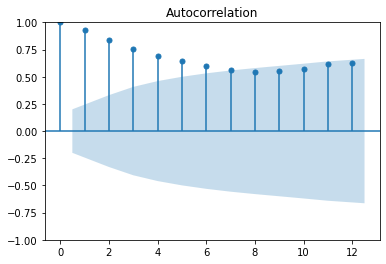

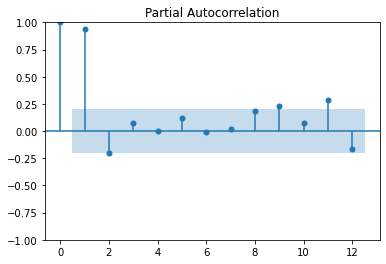

In [19]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(airline1.Passengers,lags=12)
tsa_plots.plot_pacf(airline1.Passengers,lags=12)
plt.show()


<AxesSubplot:xlabel='Month', ylabel='Passengers'>

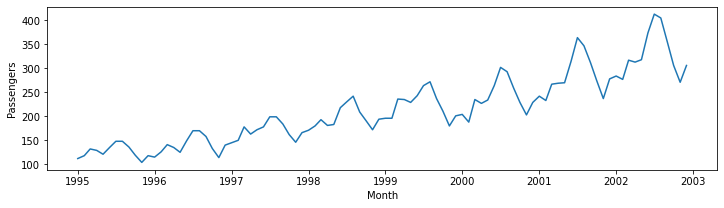

In [23]:
plt.figure(figsize=(12,3))
sns.lineplot(x="Month",y="Passengers",data=airline1)


# Splitting Data into Train &  Test Data

In [24]:
Train = airline1.head(80)
Test = airline1.tail(16)


# Model Building

### Linear Model

In [25]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear


47.542624067726734

### Exponential Model

In [26]:
Exp = smf.ols('log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp


43.79373939334317

### Quadratic Model

In [27]:
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad


43.65440369584248

### Additive Model

In [28]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea


129.26647641443313

### Additive Seasonality with Quadratic Trend

In [29]:
add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad


23.91098357010659

### Multiplicative Seasonality

In [30]:
Mul_sea = smf.ols('log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea


135.3264841462111

### Multiplicative Additive Seasonality

In [31]:
Mul_Add_sea = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 


9.469000230303608

# Comparision of Models

In [32]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])


,MODEL,RMSE_Values
6,rmse_Mult_add_sea,9.469000
4,rmse_add_sea_quad,23.910984
2,rmse_Quad,43.654404
1,rmse_Exp,43.793739
0,rmse_linear,47.542624
3,rmse_add_sea,129.266476
5,rmse_Mult_sea,135.326484


### From the above model RmSe_Multiplicative Additive seasonalitu Model we choose because it is having less Error compartively other Models.